# Data Stream Processing - Project 3 : Ideas for Extension (20%)

In [6]:
# Import librairies.
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import groupby


## The data

In [7]:
# Get files
DATAPATH =  "../data/custom_no_streaming_8/folder_2"
files = glob.glob(rf"{DATAPATH}/*")
files

['../data/custom_no_streaming_8/folder_2\\1_3.csv',
 '../data/custom_no_streaming_8/folder_2\\1_4.csv',
 '../data/custom_no_streaming_8/folder_2\\2_3.csv',
 '../data/custom_no_streaming_8/folder_2\\2_4.csv',
 '../data/custom_no_streaming_8/folder_2\\3_3.csv',
 '../data/custom_no_streaming_8/folder_2\\3_4.csv']

In [8]:
# Read anomaly files and concatenate dataframes
dfs = []
for file in files[:-1]:
    df = pd.read_csv(file)
    # Extract the filename without the parent folder path and extension
    filename = file.split('\\')[-1].split('.')[0]
    # Add a new column "anomaly_type" with the extracted filename
    df.insert(1, column="trace_id", value=filename)
    df.rename({"Unnamed: 0": "time"}, axis=1, inplace=True)
    dfs.append(df)

# Concatenate all dataframes except labels.csv
anomaly_df = pd.concat(dfs)
anomaly_df

# Rename values in the "anomaly_type" column based on the specified mapping
mapping = {
    "1_3": "bursty_input",
    "1_4": "bursty_input",
    "2_3": "stalled_input",
    "2_4": "stalled_input",
    "3_3": "cpu_contention",
    "3_4": "cpu_contention"
}
anomaly_df.insert(2, column="anomaly_type", value=anomaly_df['trace_id'].replace(mapping))

anomaly_df.head(5)

,time,trace_id,anomaly_type,driver_BlockManager_memory_memUsed_MB_value,driver_jvm_heap_used_value,avg_jvm_heap_used_value,avg_executor_filesystem_hdfs_write_ops_value_1_diff,avg_executor_cpuTime_count_1_diff,avg_executor_runTime_count_1_diff,avg_executor_shuffleRecordsRead_count_1_diff,avg_executor_shuffleRecordsWritten_count_1_diff
0,0,1_3,bursty_input,505.0,802632640.0,2.948889e+09,0.0,0.0,0.0,0.0,0.0
1,1,1_3,bursty_input,520.0,811308500.0,2.972305e+09,0.0,0.0,0.0,0.0,0.0
2,2,1_3,bursty_input,536.0,792553660.0,2.652633e+09,0.0,355610140.0,373.0,0.0,9981.0
3,3,1_3,bursty_input,482.0,779442200.0,2.686896e+09,0.0,0.0,0.0,0.0,0.0
4,4,1_3,bursty_input,497.0,789423170.0,2.706626e+09,0.0,0.0,0.0,0.0,0.0


In [9]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Charger les données
# Assurez-vous que votre fichier CSV est correctement formaté et accessible
df = anomaly_df[anomaly_df['trace_id'] == '1_3'].copy()

# Sélectionner les colonnes numériques pertinentes (exclure 'time' et 'trace_id')
cols = df.columns[3:]

# Normaliser les données
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[cols])

# Reshape data pour LSTM [samples, time steps, features]
timesteps = 1  # Vous pouvez ajuster cela selon votre séquence de temps
features = len(cols)
data = df_scaled.reshape(df_scaled.shape[0], timesteps, features)

# Construction de l'autoencodeur LSTM
inputs = Input(shape=(timesteps, features))
encoded = LSTM(10, return_sequences=False)(inputs)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(features, return_sequences=True)(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Entraîner le modèle
autoencoder.fit(data, data, epochs=20, batch_size=128, validation_split=0.2, shuffle=True)

# Prédire les données reconstruites
predictions = autoencoder.predict(data)

# Calculer l'erreur de reconstruction
mse = np.mean(np.power(data - predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse[:,0]})

# Identifier les anomalies (Vous pouvez définir un seuil d'erreur)
threshold = np.percentile(error_df.Reconstruction_error.values, 95)
anomalies = error_df[error_df.Reconstruction_error > threshold]




Epoch 1/20

162/162 [==============================] - 5s 9ms/step - loss: 0.7180 - val_loss: 1.9408
Epoch 2/20
162/162 [==============================] - 1s 5ms/step - loss: 0.5791 - val_loss: 1.8608
Epoch 3/20
162/162 [==============================] - 1s 4ms/step - loss: 0.4703 - val_loss: 1.7995
Epoch 4/20
162/162 [==============================] - 1s 5ms/step - loss: 0.4121 - val_loss: 1.7646
Epoch 5/20
162/162 [==============================] - 1s 5ms/step - loss: 0.3806 - val_loss: 1.7502
Epoch 6/20
162/162 [==============================] - 1s 5ms/step - loss: 0.3646 - val_loss: 1.7439
Epoch 7/20
162/162 [==============================] - 1s 5ms/step - loss: 0.3551 - val_loss: 1.7411
Epoch 8/20
162/162 [==============================] - 1s 5ms/step - loss: 0.3490 - val_loss: 1.7411
Epoch 9/20
162/162 [==============================] - 1s 5ms/step - loss: 0.3446 - val_loss: 1.7400
Epoch 10/20
162/162 [==============================] - 1s 6ms/step - loss: 0.3405 - val_loss: 1.7

C:\Users\choho\AppData\Local\Temp\ipykernel_20680\520005481.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error_df.Reconstruction_error.values, bins=50, kde=True, color='blue')


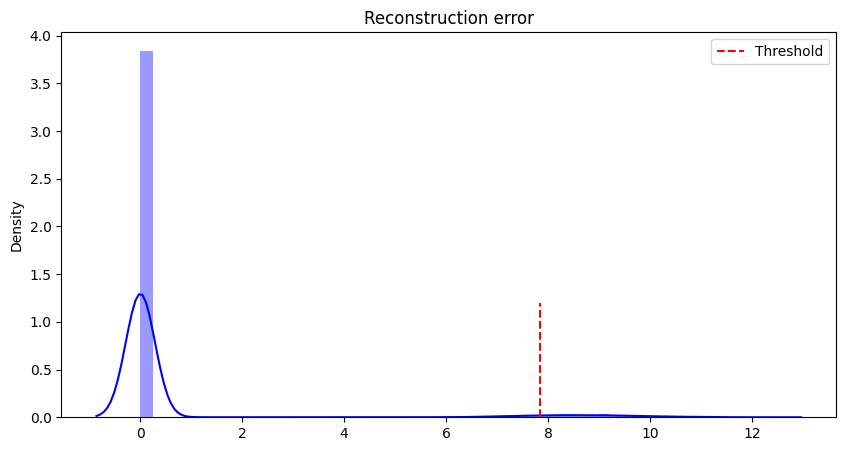

Pourcentage d'anomalies:  5.002520649939892


In [10]:
# TODO : gerer la continuité des anomalies car y'a certains points qui sont pas détectés comme des anomalies dans le segments des anomalies

# Plot reconstruction error
plt.figure(figsize=(10, 5))
plt.title("Reconstruction error")
sns.distplot(error_df.Reconstruction_error.values, bins=50, kde=True, color='blue')
plt.vlines(threshold, 0, 1.2, colors='r', linestyles='--', label='Threshold')
plt.legend(loc='best')
plt.show();



# calculer le pourcentage d'anomalies base min max index C
anomaly_ratio = 100*anomalies.shape[0] / error_df.shape[0]
print('Pourcentage d\'anomalies: ', anomaly_ratio)

C:\Users\choho\AppData\Local\Temp\ipykernel_20680\2435052025.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['time'] = anomalies.index


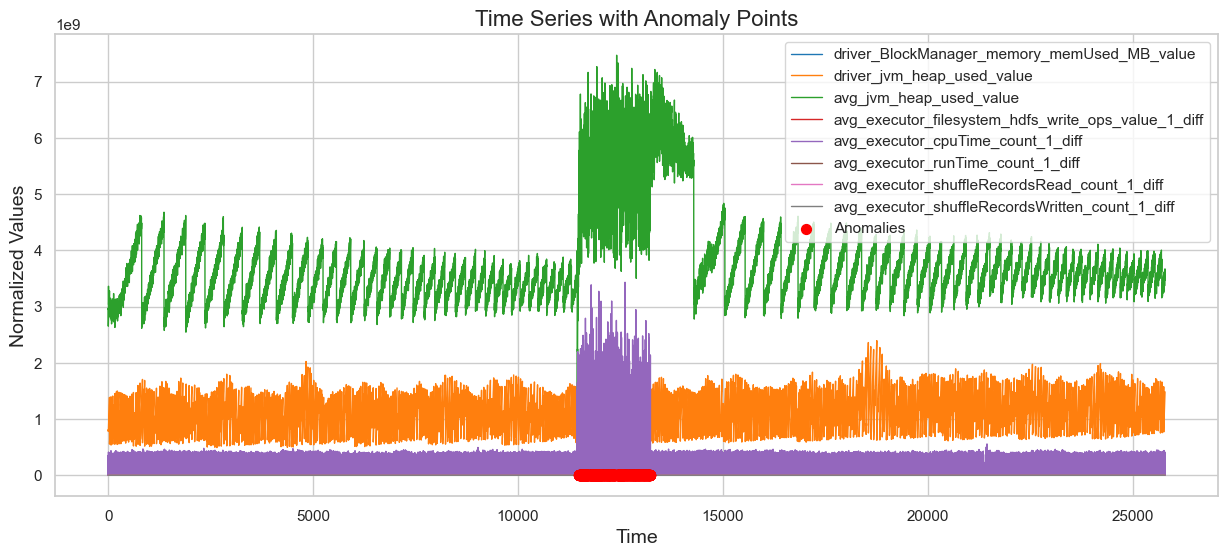

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ajouter la colonne 'time' pour référence temporelle
anomalies['time'] = anomalies.index

# Set the Seaborn style for better aesthetics
sns.set(style='whitegrid')

# Define color palette for the time series
colors = sns.color_palette('tab10', len(cols))

# Create a figure and axis for the plot
plt.figure(figsize=(15, 6))
ax = plt.gca()

# Plot each time series with a thinner line
for i, col in enumerate(cols):
    ax.plot(df['time'], df[col], color=colors[i], linewidth=1, label=col)

# Highlight anomaly points with red color
ax.scatter(anomalies['time'], df.loc[anomalies.index, cols[0]], color='red', s=50, label='Anomalies', zorder=5)

# Set title and labels with appropriate font sizes
ax.set_title('Time Series with Anomaly Points', fontsize=16)
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Normalized Values', fontsize=14)

# Place the legend in the upper right corner of the plot
ax.legend(loc='upper right', frameon=True)

# Display the plot
plt.show()
